<a href="https://colab.research.google.com/github/kenanmorani/COV19D/blob/main/3D_Image_Classification_with_Modified_UNET_Architecture.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os, glob
import numpy as np
import matplotlib.pyplot as plt
import cv2
import nibabel as nib

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow import keras
from keras.models import load_model
from keras import backend as K
import seaborn as sns
from keras.applications.vgg16 import VGG16

In [19]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


# Organizing the training and validation sets of images using ImageDataGenerator

In [4]:
in_h = 224
in_w = 224

batch_size = 32

In [5]:
train_datagen = None
train_generator = None

train_datagen = ImageDataGenerator(rescale=1./255, 
                                   horizontal_flip= True, vertical_flip=True)
train_generator = train_datagen.flow_from_directory(
        '/content/gdrive/MyDrive/Covid_data/Training Set/1-100',  
        target_size=(in_h, in_w),  
        batch_size=batch_size,
        color_mode="grayscale",
        classes = ['covid','non-covid'],
        class_mode='binary')

Found 36592 images belonging to 2 classes.


In [6]:
val_datagen = ImageDataGenerator(rescale=1/255)
val_generator = val_datagen.flow_from_directory(
        '/content/gdrive/MyDrive/Covid_data/Validation Set/1-100',  
        target_size=(in_h, in_w),  
        batch_size=batch_size,
        color_mode="grayscale",
        classes = ['covid','non-covid'],
        class_mode='binary')

Found 15598 images belonging to 2 classes.


# Modified UNET#

In [7]:
import keras
from tensorflow.keras import regularizers
from keras.regularizers import l2

#Building 2D-UNET model
def unet(n_levels, initial_features=32, n_blocks=2, kernel_size=3, pooling_size=2, in_channels=1, out_channels=1):
    inputs = keras.layers.Input(shape=(in_h, in_w, in_channels))
    x = inputs
    
    convpars = dict(kernel_size=kernel_size, activation='relu', padding='same')
    #downstream
    skips = {}
    for level in range(n_levels):
        for _ in range(n_blocks):
            x = keras.layers.Conv2D(initial_features * 2 ** level, kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01), **convpars)(x)
            #x = keras.layers.BatchNormalization()(x)
        if level < n_levels - 1:
            skips[level] = x
            x = keras.layers.MaxPool2D(pooling_size)(x)
            #x = keras.layers.BatchNormalization()(x)

    #upstream
    for level in reversed(range(n_levels-1)):
        x = keras.layers.Conv2DTranspose(initial_features * 2 ** level, strides=pooling_size, 
                                         kernel_regularizer=l2(0.01),  **convpars)(x) 
                                         #bias_regularizer=l2(0.01),
        x = keras.layers.Concatenate()([x, skips[level]])
        for _ in range(n_blocks):
            x = keras.layers.Conv2D(initial_features * 2 ** level, 
                                    kernel_regularizer=l2(0.01), **convpars)(x)
                                    # bias_regularizer=l2(0.01),      
    
    # output
    #activation = 'sigmoid' if out_channels == 1 else 'softmax'
    #x = keras.layers.Conv2D(out_channels, kernel_size=3, activation=activation, padding='same')(x)
    #x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Flatten()(x)
    x = keras.layers.Dense(256, activation='relu')(x)
    #x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Dropout(0.1)(x)
    x = keras.layers.Dense(1, activation='sigmoid')(x)
    
    return keras.Model(inputs=[inputs], outputs=[x], name=f'UNET-L{n_levels}-F{initial_features}')

In [8]:
model = unet(3)

In [9]:
model.summary()

Model: "UNET-L3-F32"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 224, 224, 32) 320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 224, 224, 32) 9248        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 112, 112, 32) 0           conv2d_1[0][0]                   
________________________________________________________________________________________

# Modified UNET


In [10]:
model.compile(loss='binary_crossentropy',
              optimizer = 'Adam',
              metrics=[tf.keras.metrics.Precision(),tf.keras.metrics.Recall(),'accuracy'])

In [22]:
from sklearn.utils import class_weight 
from collections import Counter


counter = Counter(train_generator.classes)                          
max_val = float(max(counter.values()))       
class_weights = {class_id : max_val/num_images for class_id, num_images in counter.items()}  
class_weights


{0: 1.0860840316971667, 1: 1.0}

In [11]:
steps_per_epoch_train = len(train_generator) // batch_size
steps_per_epoch_train

35

In [12]:
steps_per_epoch_validation = len(val_generator) // batch_size
steps_per_epoch_validation

15

In [13]:
n_epochs = 11
history=model.fit(train_generator,
                  #class_weight=class_weights,
                  steps_per_epoch= steps_per_epoch_train,
                  validation_data=val_generator,
                  validation_steps=steps_per_epoch_validation,
                  #callbacks=[early_stopping_cb],
                  verbose=2,
                  epochs=n_epochs)

model.save('/content/gdrive/MyDrive/Covid_data/Saved-model/model1.h5')

Epoch 1/11
35/35 - 1338s - loss: 6.6887 - precision: 0.5315 - recall: 0.6114 - accuracy: 0.5205 - val_loss: 3.0961 - val_precision: 0.6029 - val_recall: 0.9931 - val_accuracy: 0.6021
Epoch 2/11
35/35 - 1330s - loss: 2.4730 - precision: 0.6667 - recall: 0.5958 - accuracy: 0.6402 - val_loss: 2.0836 - val_precision: 0.6247 - val_recall: 0.9336 - val_accuracy: 0.6458
Epoch 3/11
35/35 - 1319s - loss: 1.6982 - precision: 0.8642 - recall: 0.7428 - accuracy: 0.8027 - val_loss: 2.0213 - val_precision: 0.6923 - val_recall: 0.6585 - val_accuracy: 0.6208
Epoch 4/11
35/35 - 1322s - loss: 1.3232 - precision: 0.9078 - recall: 0.8956 - accuracy: 0.8964 - val_loss: 1.9021 - val_precision: 0.7232 - val_recall: 0.6877 - val_accuracy: 0.6583
Epoch 5/11
35/35 - 1313s - loss: 1.0824 - precision: 0.9574 - recall: 0.9477 - accuracy: 0.9500 - val_loss: 1.8807 - val_precision: 0.7321 - val_recall: 0.5688 - val_accuracy: 0.6417
Epoch 6/11
35/35 - 1311s - loss: 0.9377 - precision: 0.9709 - recall: 0.9621 - accura

OSError: ignored

In [23]:
model.save('/content/gdrive/MyDrive/Covid_data/model1.h5')

In [27]:
Train_accuracy = history.history['accuracy']
print(np.mean(Train_accuracy))

0.8814123435453936


In [25]:
val_accuracy = history.history['val_accuracy']
print(np.mean(val_accuracy))

0.6551136320287531


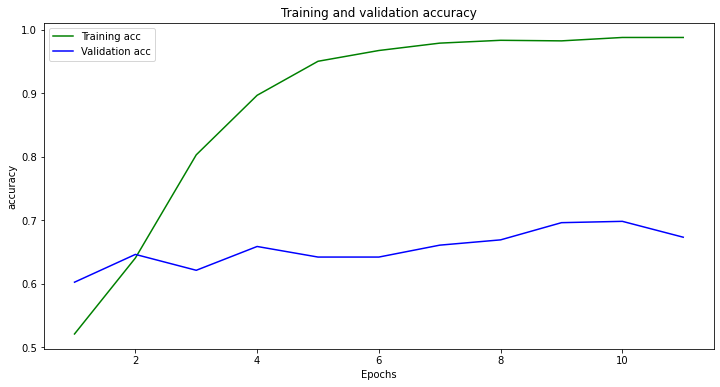

In [29]:
epochs = range(1, len(Train_accuracy)+1)
plt.figure(figsize=(12,6))
plt.plot(epochs, Train_accuracy, 'g', label='Training acc')
plt.plot(epochs, val_accuracy, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend()

In [33]:
val_recall = history.history['val_recall']
avg_recall = np.mean(val_recall)
avg_recall

0.7201583602211692

In [32]:
val_precision = history.history['val_precision']
avg_precision = np.mean(val_precision)
avg_precision

0.710565371946855

(0.0, 1.0)

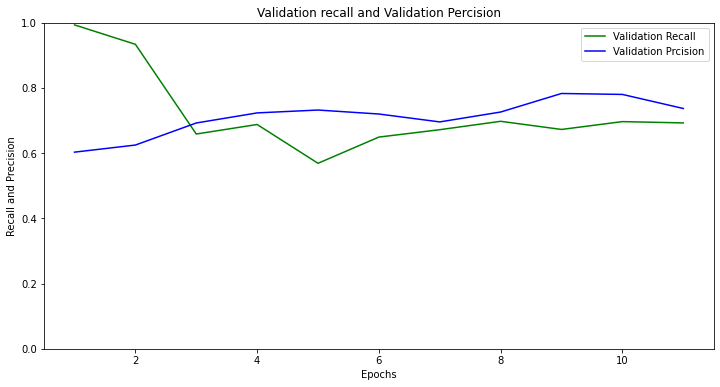

In [34]:
epochs = range(1, len(Train_accuracy)+1)
plt.figure(figsize=(12,6))
plt.plot(epochs, val_recall, 'g', label='Validation Recall')
plt.plot(epochs, val_precision, 'b', label='Validation Prcision')
plt.title('Validation recall and Validation Percision')
plt.xlabel('Epochs')
plt.ylabel('Recall and Precision')
plt.legend()
plt.ylim(0,1)

In [35]:
Macro_F1score = (2*avg_precision*avg_recall)/ (avg_precision + avg_recall)
Macro_F1score

0.7153297056389304